In [18]:
import os
from dotenv import load_dotenv, find_dotenv
load_dotenv(find_dotenv())

from langchain_openai import AzureChatOpenAI

from typing import Annotated

from langchain_anthropic import ChatAnthropic
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

In [19]:
class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

In [20]:
tool = TavilySearchResults(max_results=2)
tools = [tool]

In [21]:
llm = AzureChatOpenAI(
    api_key=os.getenv("AZURE_OPENAI_API_KEY"),
    api_version=os.getenv("API_VERSION"),
    azure_endpoint=os.getenv("AZURE_OPENAI_ENDPOINT"),
    model=os.getenv("MODEL_NAME"),
    )
llm_with_tools = llm.bind_tools(tools)

In [22]:
def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

In [23]:
graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")

In [25]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

In [26]:
graph_builder.set_entry_point("chatbot")
graph = graph_builder.compile(checkpointer=memory)

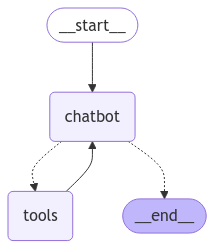

In [27]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [28]:
config = {"configurable": {"thread_id": "1"}}
user_input = "Hi there! My name is Will."

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Hi there! My name is Will.
================================== Ai Message ==================================

Hello Will! How can I assist you today?


In [29]:
user_input = "Remember my name?"

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Remember my name?
================================== Ai Message ==================================

Yes, your name is Will. How can I assist you today?


In [32]:
# The only difference is we change the `thread_id` here to "2" instead of "1"
events = graph.stream(
    {"messages": [("user", user_input)]},
    {"configurable": {"thread_id": "2"}},
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Remember my name?
================================== Ai Message ==================================

I don't have access to personal data about you unless you provide it in this conversation. If you'd like to tell me your name, I'd be happy to use it in our conversation!


In [34]:
snapshot = graph.get_state(config)
print(snapshot)

StateSnapshot(values={'messages': [HumanMessage(content='Hi there! My name is Will.', additional_kwargs={}, response_metadata={}, id='34889a65-6955-4508-acbd-1700fc4ee1a7'), AIMessage(content='Hello Will! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 11, 'prompt_tokens': 87, 'total_tokens': 98, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_d54531d9eb', 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'jailbreak': {'filtered': False, 'detected': False}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': False, 'severity': 'safe'}}}], 'finish_reason': 'stop', 'logprobs': None, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'protected_material_code': {'fi

In [35]:
snapshot.next

()